# 使用ModelScope ViT模型完成图像分类模型微调和部署

## 背景介绍


[ModelScope](https://www.modelscope.cn)是一个旨在为泛AI开发者提供灵活、易用、低成本的一站式“模型即服务”（MaaS）的开源平台。它汇集了丰富的预训练模型，覆盖了NLP、CV、Audio、AIGC、多模态大模型等多个领域。利用ModelScope所提供的模型以及ModelScope Library，开发者可以用一行代码实现模型推理，或者用十几行代码实现对预训练模型的调优训练，方便开发者基于行业数据集快速构建专属行业模型。

当前示例中，我们以[ViT图像分类-通用](https://modelscope.cn/models/damo/cv_vit-base_image-classification_ImageNet-labels/summary) 为示例，展示如何在PAI完成一个ModelScope模型的微调训练，然后将获得的模型部署为一个在线推理服务的过程。主要流程包括：

1. 准备工作：

安装PAI Python SDK，并完成SDK配置。

2. 模型的微调训练

编写微调训练脚本，使用[花朵分类](https://www.modelscope.cn/models/zydfx1111/flower)数据集对模型进行微调训练，以获得一个可以用于花朵分类的模型。

3. 部署推理服务

将微调训练作业输出的模型，部署到PAI-EAS，创建一个在线推理服务。

## 前提条件

- 已获取阿里云账号的鉴权AccessKey ID和AccessKey Secret，详情请参见：[获取AccessKey](https://help.aliyun.com/document_detail/116401.html)。
- 已创建或是加入一个PAI AI工作空间，详情请参见：[创建工作空间](https://help.aliyun.com/document_detail/326193.html)。
- 已创建OSS Bucket，详情请参见：[控制台创建存储空间](https://help.aliyun.com/document_detail/31885.html)。


## Step1: 准备工作

我们将使用PAI提供的Python SDK，提交训练作业，部署模型。可以通过以下命令安装PAI Python SDK。

In [ ]:
!python -m pip install --upgrade alipai


SDK需要配置访问阿里云服务需要的 AccessKey，以及当前使用的工作空间和OSS Bucket。在PAI Python SDK安装之后，通过在 **命令行终端** 中执行以下命令，按照引导配置密钥，工作空间等信息。


```shell

# 以下命令，请在 命令行终端 中执行.

python -m pai.toolkit.config

```

我们可以通过以下代码验证当前的配置。

In [ ]:
import pai
from pai.session import get_default_session

print(pai.__version__)
sess = get_default_session()

assert sess.workspace_name is not None
print(sess.workspace_name)

## Step2: 提交微调训练作业

ModelScope的[ViT图片分类-通用](https://modelscope.cn/models/damo/cv_vit-base_image-classification_ImageNet-labels/summary)模型使用经典的[ViT Base](https://github.com/google-research/vision_transformer)模型结构，在ImageNet-1k数据集进行预训练，可以直接用于[ImageNet 1k标签](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)覆盖图像的分类任务，也可以作为下游任务的预训练模型。

当前示例，我们将以[花朵分类数据集](https://www.modelscope.cn/datasets/tany0699/flowers14/summary)对模型进行微调训练，从而获得一个可以用于花朵分类的模型。

### 准备微调训练脚本

ModelScope提供了功能完善的Python Library，能够支持用户方便得使用ModelScope模型进行推理以及微调训练，在本示例中，我们将使用ModelScope Library编写相应的微调训练脚本，然后提交到PAI执行微调训练作业。


In [ ]:

# 准备相应训练作业脚本目录
!mkdir -p train_src

完整的微调训练脚本代码如下：

> 对于ModelScope library的使用介绍，请参见：[ModelScope文档](https://www.modelscope.cn/docs/ModelScope%20Library%E6%A6%82%E8%A7%88%E4%BB%8B%E7%BB%8D)

In [ ]:
%%writefile train_src/finetune.py

import os
import re
import logging
import shutil


from modelscope.msdatasets import MsDataset
from modelscope.metainfo import Trainers
from modelscope.trainers import build_trainer


# 从环境变量中获取超参（由PAI的训练服务注入）
BATCH_SIZE = int(os.environ.get("PAI_HPS_BATCH_SIZE", 16))
LEARNING_RATE = float(os.environ.get("PAI_HPS_INITIAL_LEARNING_RATE", 1e-3))
NUM_EPOCHS = int(os.environ.get("PAI_HPS_EPOCHS", 1))
NUM_CLASSES = int(os.environ.get("PAI_HPS_NUM_CLASSES", 14))
MODEL_ID_OR_PATH = os.environ.get("PAI_INPUT_MODEL", "damo/cv_vit-base_image-classification_ImageNet-labels")

# 通过环境变量获取输出模型，和checkpoints保存路径
OUTPUT_MODEL_DIR = os.environ.get("PAI_OUTPUT_MODEL", "./model/")
WORK_DIR = os.environ.get("PAI_OUTPUT_CHECKPOINTS", "./checkpoints/")


# 将产出的模型保存到模型输出目录(OUTPUT_MODEL_DIR)
def save_model():
    best_ckpt_pattern = re.compile(
        pattern=r"^best_accuracy_top-1_epoch_\d+.pth$"
    )
    print("Saving best checkpoint as pytorch_model.pt")
    print("List work dir: ", os.listdir(WORK_DIR))

    f_name = next((f for f in os.listdir(WORK_DIR) if best_ckpt_pattern.match(f)), None)
    if f_name:
        # 使用最佳checkpoints作为输出模型
        print("Found best checkpoint: ", f_name)
        shutil.copyfile(
            src=os.path.join(WORK_DIR, f_name),
            dst=os.path.join(OUTPUT_MODEL_DIR, "pytorch_model.pt"),
        )
        os.remove(os.path.join(WORK_DIR, f_name))
    else:
        # 如果没有，则使用最后一个epoch的checkpoints作为输出模型
        print("Not found best checkpoint.")
        last_ckpt_file = "epoch_{}.pth".format(NUM_EPOCHS)
        if os.path.isfile(os.path.join(WORK_DIR, last_ckpt_file)):
            shutil.copyfile(
                src=os.path.join(WORK_DIR, last_ckpt_file),
                dst=os.path.join(OUTPUT_MODEL_DIR, "pytorch_model.pt"),
            )
        else:
            print("Not found latest checkpoint: {}.".format(os.path.join(WORK_DIR, last_ckpt_file)))
    # 模型配置信息
    shutil.copyfile(
        src=os.path.join(WORK_DIR, "configuration.json"),
        dst=os.path.join(OUTPUT_MODEL_DIR, "configuration.json"),
    )


# 修改配置文件
def cfg_modify_fn(cfg):
    cfg.train.dataloader.batch_size_per_gpu = BATCH_SIZE # batch大小
    cfg.train.dataloader.workers_per_gpu = 8     # 每个gpu的worker数目
    cfg.train.max_epochs = NUM_EPOCHS                     # 最大训练epoch数
    cfg.model.mm_model.head.num_classes = NUM_CLASSES                       # 分类数
    cfg.model.mm_model.train_cfg.augments[0].num_classes = NUM_CLASSES      # 分类数
    cfg.model.mm_model.train_cfg.augments[1].num_classes = NUM_CLASSES      # 分类数
    cfg.train.optimizer.lr = LEARNING_RATE                # 学习率
    cfg.train.lr_config.warmup_iters = 1         # 预热次数

    # Note: OSS挂载到输出路径中，不支持软链接.
    cfg.train.checkpoint_config.create_symlink = False


    return cfg

def train():
    ms_train_dataset = MsDataset.load(
                'flowers14', namespace='tany0699',
                subset_name='default', split='train') # 加载训练集

    ms_val_dataset = MsDataset.load(
                'flowers14', namespace='tany0699',
                subset_name='default', split='validation') # 加载验证集


    # 构建训练器
    kwargs = dict(
        model=MODEL_ID_OR_PATH,                 # 模型id
        work_dir=WORK_DIR,
        train_dataset=ms_train_dataset, # 训练集  
        eval_dataset=ms_val_dataset,    # 验证集
        cfg_modify_fn=cfg_modify_fn     # 用于修改训练配置文件的回调函数
    )
    trainer = build_trainer(name=Trainers.image_classification, default_args=kwargs)

    # 进行训练
    trainer.train()

    # 进行评估
    result = trainer.evaluate()
    print('Evaluation Result:', result)

    # 保存模型
    save_model()

if __name__ == "__main__":
    train()
    

在当前的训练作业中，我们将使用PAI提供的PyTorch训练镜像，需要在镜像中安装ModelScope Library。通过在训练作业脚本目录下准备一个`requirements.txt`文件，可以在训练作业启动时，自动安装依赖的第三方库。

In [ ]:
%%writefile train_src/requirements.txt


# 部分ModelScope依赖library由ModelScope Host，需要显式配置以下参数
--find-links https://modelscope.oss-cn-beijing.aliyuncs.com/releases/repo.html
modelscope[cv]==1.3.1

完整的训练作业脚本目录结构如下：

```shell

train_src
    ├── finetune.py
    └── requirements.txt

```

后续我们将通过PAI Python SDK将训练脚本提交到PAI执行。


### 提交训练作业到PAI

SDK提供了High-Level的API，`pai.estimator.Estimator`，支持用户方便地使用镜像配合训练脚本，提交训练作业到PAI。以下代码中，我们将使用以上的训练作业脚本（`train_src`目录），配合PAI提供的PyTorch训练镜像，提交一个训练作业。

对于如何使用SDK提交训练作业的详细介绍，可以见文档：[提交训练作业](https://help.aliyun.com/document_detail/2261505.html)


In [ ]:
from pai.estimator import Estimator
from pai.image import retrieve


# 使用PAI提供的最新的PyTorch GPU镜像
torch_img_uri = retrieve(
    "PyTorch",
    "latest",
    accelerator_type="gpu",
).image_uri

# 使用训练配置信息，创建Estimator对象
est = Estimator(
    command="python finetune.py",  # 训练作业的启动命令
    source_dir="train_src",  # 训练作业脚本本地目录（绝对路径，或是相对路径）
    image_uri=torch_img_uri,  # 作业的镜像类型
    # instance_type="ecs.gn6e-c12g1.3xlarge",   # 12vCPU 92GiB NVIDIA V100 × 1 (32GB GPU memory)
    instance_type="ecs.gn7i-c8g1.2xlarge",  # 8vCPU 30GiB NVIDIA A10 × 1 (24GB GPU Memory)
    base_job_name="vit-finetune",  # 作业名称
    hyperparameters={  # 训练作业超参，用户可以通过环境变量或是读取配置文件的方式获取.
        "batch_size": 128,
        "initial_learning_rate": 1e-4,
        "epochs": 2,
        # 花朵数据集一共14个分类
        "num_classes": 14,
    },
)

通过`fit` API提交训练作业。当前示例中，我们在训练脚本中使用ModelScope的library去下载数据集。当用户需要使用自定义数据集时，可以通过`fit`方法传递相应数据OSS路径，训练作业会通过挂载的方式将相应的数据准备的执行环境中。

```python

est.fit(
	# 用户的训练作业脚本可以通过环境变量 PAI_INPUT_{ChannelNameUpperCase} 获得数据的本地路径.
	"train": "oss://<your-bucket>/train/data/path/",
)

```

In [ ]:
est.fit()

训练作业执行成功之后，用户可以通过`estimator.model_data()`获取相应产出模型的OSS路径

## Step3: 部署推理服务

PAI-EAS是PAI提供的推理服务部署平台，支持使用Processor或是镜像的方式部署推理服务。在以下的流程中，我们将使用微调获得的模型，使用镜像部署的方式部署一个在线推理服务。

### 准备推理服务使用的代码

镜像部署的模式，要求用户提供一个推理服务程序，他负责加载模型，提供HTTP API，以支持接受用户推理请求，调用模型处理推理请求，返回推理结果。在当前示例中，我们将使用[FastAPI](https://fastapi.tiangolo.com/)编写一个推理服务程序，加载以上训练作业输出的模型，在PAI创建一个推理服务。

我们首先创建一个目录(`serve_src`)，用于保存的推理服务程序代码。


In [ ]:
!mkdir -p serve_src/

我们准备的推理服务程序，支持用户通过HTTP POST发送的图片，然后调用ModelScope的推理pipeline获取预测结果，返回给到用户。

> ModelScope 推理pipeline返回的结果中带有`numpy.ndarray`数据，需要我们通过自定义Encoder将其序列化。

完整代码如下，我们将其保存到`serve_src`目录下，用于后续创建推理服务。

In [ ]:
%%writefile serve_src/run.py

import os
import io
import json

import uvicorn
from fastapi import FastAPI, Response, Request
import numpy as np

from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
from PIL import Image

# 用户指定模型，默认会被加载到当前路径下。 
MODEL_PATH = "/eas/workspace/model/"

class NumpyEncoder(json.JSONEncoder):

    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.generic):
            return obj.item()
        else:
            return json.JSONEncoder.default(self, obj)

app = FastAPI()

@app.post("/")
async def predict(request: Request):
    global p
    content = await request.body()
    img = Image.open(io.BytesIO(content))
    res = p(img)
    return Response(content=json.dumps(res, cls=NumpyEncoder), media_type="application/json")


if __name__ == '__main__':
    p = pipeline(
        Tasks.image_classification,
        model=MODEL_PATH,
    )
    uvicorn.run(app, host='0.0.0.0', port=8000)


### 创建推理服务

我们将使用PAI提供的ModelScope推理镜像，使用以上的推理服务程序，创建一个推理服务。

In [ ]:
from pai.model import container_serving_spec
from pai.session import get_default_session
from pai.model import Model
from random import randint


# 使用PAI QuickStart提供的ModelScope的镜像创建推理服务
image_uri = (
    "registry.{}.aliyuncs.com/paiflow-public/quickstart:modelscope-1.2.0".format(
        get_default_session().region_id,
    )
)


# 创建一个Model对象，他可以用于创建推理服务
m: Model = Model(
    # 使用以上训练作业产出的模型
    model_data=est.model_data(),
    # 配置模型的推理配置，包括使用的镜像，使用的推理服务脚本，推理的依赖包等。
    inference_spec=container_serving_spec(
        source_dir="./serve_src/",
        command="python run.py",
        image_uri=image_uri,
        requirements=[
            "fastapi",
            "uvicorn",
        ],
    ),
)


print(m.inference_spec.to_dict())

指定推理服务的名称，以及使用的机器实例规格，创建一个推理服务。

In [ ]:
from pai.predictor import Predictor


p: Predictor = m.deploy(
    service_name="modelscope_vit_{}".format(randint(0, 100000)),
    instance_type="ecs.c6.xlarge",
    options={
        # 推理镜像较大的镜像下，需要配置额外的磁盘空间
        "features.eas.aliyun.com/extra-ephemeral-storage": "40GB"
    },
)

`model.deploy` 返回的`Predictor`对象可以用于向相应的推理服务发送请求，获得推理结果。


这里我们使用已经准备的一张花朵图片测试推理服务。

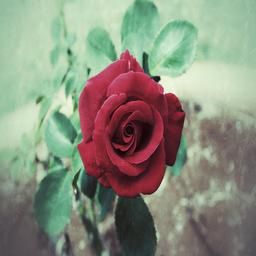

In [ ]:
import io

import requests
from PIL import Image
from IPython import display

url = "https://pai-sdk.oss-cn-shanghai.aliyuncs.com/resources/images/11563567033_b822736d84_c.jpeg"

data = requests.get(url).content

display.display(Image.open(io.BytesIO(data)))

In [ ]:
from pai.predictor import RawResponse

resp: RawResponse = p.raw_predict(data=data)

print(resp.json())


在测试完成之后，我们可以将创建的服务删除。

In [ ]:
p.delete_service()